# Section 1 - Overview

In this emotion recognition project, we have 29000 original training data and 6887 images inthe test dataset that need to be predicted. We have explored different models such as RandomForest, DNN, CNN, and ResNet, along with various configurations to identify the most effectivesolution. The methodology involved initial data analysis, preprocessing, and subsequent modelexperimentation to test various model performances.  

Key Findings:
* Random Forest: The model exhibited high training accuracy but performed poorly onvalidation, indicating overfitting. Tuning the 'min_samples_split' parameter improved validationaccuracy marginally.
* DNN: The performance of DNN slightly exceeded that of the Random Forest. A systematicapproach, as advised by the referenced literature, helped mitigate overfitting to some extent.
* CNN: The experiments with CNN indicated the delicate balance between neuron count andoverfitting, with a learning rate of around 0.001 providing optimal results. Increasing complexityvia additional layers did not significantly benefit ResNet's performance.
* ResNet: Adjustments to ResNet, such as modifying the number of layers and strides, hadnuanced effects on performance, with some configurations indicating potential overfitting.  

The suggested model is ResNet without data augmentation, achieving 85% validationaccuracy and 0.58 Kaggle competition score. The analysis indicates that while dataaugmentation offers performance benefits, the trade-off against increased training time maynot be justified given project constraints.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# Section 2 - Method

### <i>2.1 - Load data & Explore the data</i>

By looking at the first few examples of the training set, we noticed that the training set has been shuffled already (i.e., ids are disorder and class labels are intertwined), hence we may not need to perform dataset shuffling when splitting the data. We used function <code>count()</code> to see how many examples there are. In the meantime, we checked that there are no NULL values in the dataset; therefore, we do not need to drop any examples. Lastly, we explored the data type of the feature column <b>'pixels'</b> to get a picture of how to deal with it (i.e., object type -> numerical type).  

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/my_emotion_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/my_emotion_test.csv')

In [ ]:
# Explore the data set
train_df.head(5) # View the first five examples of the training set
train_df.count() # Check the number of examples
train_df.isna().any() # Check if there is any NULL value exists
train_df['pixels'].dtype # Check the data type of the feature column 'pixels'

We further explored the dataset by displaying examples (images). We picked one example from each class and plotted them together to have a comprehensive understanding of their characteristics. More importantly, we realised that it is feasible to rescale/resize/crop examples during the preprocessing stage because features of emotions (such as the eye area, cheek area, and mouth area) are mostly located around the centre or middle of images, which means only the information at the centre will be useful for our models, the others can be reduced.

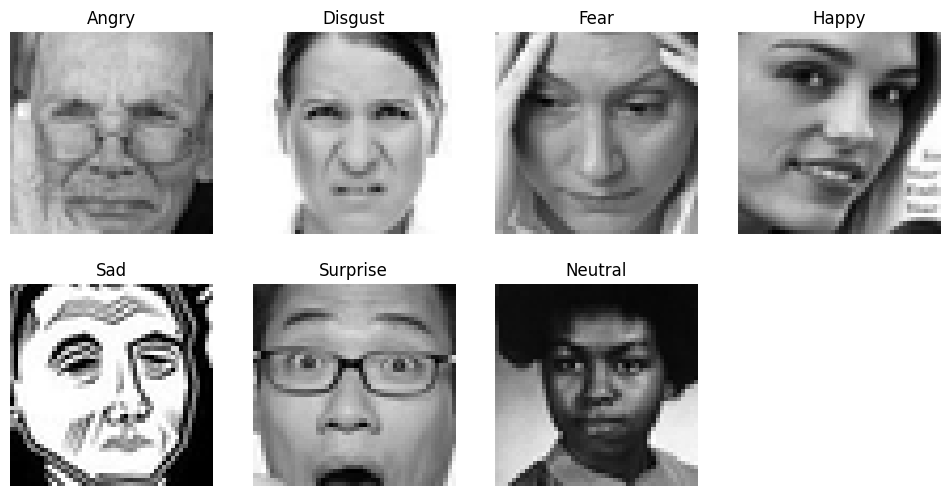

In [4]:
# Explore the data set (i.e., preview examples)
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
axarr[-1, -1].axis('off')
for label, emotion_name in emotions.items():
    # Find the first example of each emotion
    example = train_df[train_df['emotion'] == label].iloc[0]

    # Split the pixel string into a list of integers
    pixels = list(map(int, example['pixels'].split(' ')))

    # Assuming it's a 48x48 image, reshape it
    image_array = np.array(pixels).reshape(48, 48)

    # Display the image with the emotion label
    i = 0 if label<4 else 1
    j = label % 4
    fig.add_subplot(2, 4, label+1, title=emotion_name)
    axarr[i,j].axis('off')
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')

### <i>2.2 - Data preprocessing</i>

The first thing we need to do for data preprocessing is convert the feature <b>'pixels'</b> into a numerical type like an array of int, and then our model can use it to train.

In [5]:
# Convert the feature 'pixels' from string into ndarray
X_train = np.array([np.fromstring(x, dtype=int, sep=' ') for x in train_df['pixels']])
y_train = train_df['emotion']
X_test = np.array([np.fromstring(x, dtype=int, sep=' ') for x in test_df['pixels']])

By using the functions <code>min() & max()</code>, we can see that the value range of the training data (pixel values) scales from <b>0 -> 255</b>, which means we can scale it down to <b>0 -> 1</b> by dividing it by 255 and not change its distribution.

In [6]:
X_train.min() # Check the minimum value
X_train.max() # Check the maximum value

# Scale piexel values from 0 -> 255 to 0 -> 1
X_train = X_train/255
X_test = X_test/255

As mentioned earlier, we deployed a function called <code>centerCropping</code> used to crop the central area of images, which will reduce the image dimensions from 48 x 48 down to 40 x 40 for example. Another function named <code>smallerDS</code>, as its name says this function is used to produce a smaller dataset by cropping every image of that dataset.

In [1]:
import math

# Center crop an image down to a desired size (e.g., 40*40)
def centerCropping(img, original_Size, target_Size):
  if original_Size == target_Size:
    return img
  image = img.reshape(original_Size, original_Size)
  pixels_ToRemove = (original_Size - target_Size) // 2
  cropped_image = image[pixels_ToRemove-1:original_Size-pixels_ToRemove-1,
                        pixels_ToRemove-1:original_Size-pixels_ToRemove-1]
  return cropped_image

# Return a smaller dataset by reducing the size of each example
def smallerDS(ds, desired_Size):
  cropped_DS = []
  for image in ds:
    original_Size = int(math.sqrt(len(image)))
    cropped_DS.append(centerCropping(image, original_Size, desired_Size).reshape(-1))
  return np.asarray(cropped_DS)

Select one image and verify the effect of centre cropping. We can see that all those useful features are still retained, but the image size has been significantly reduced from 2304 pixels down to 1600 pixels. In other words, we have removed <b>704</b> less useful features for each example (there are 29000 examples in total), this is very useful to speed up model training!

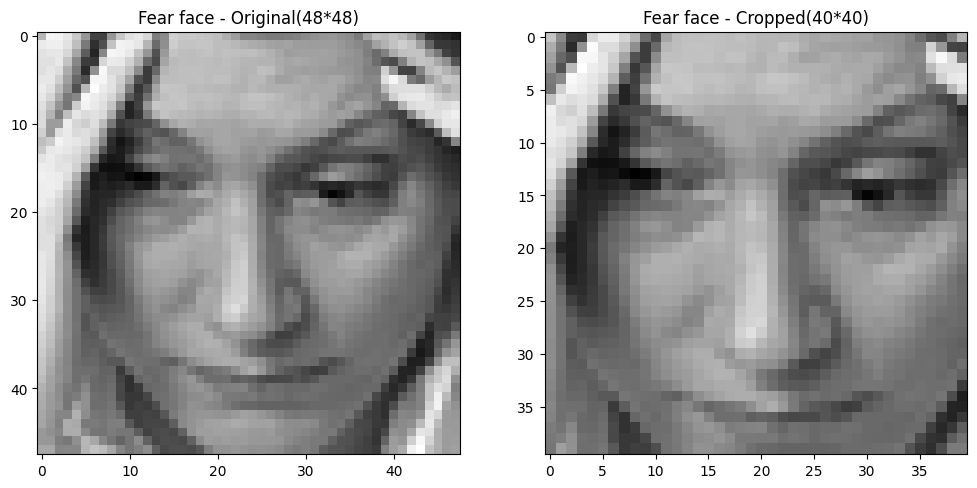

In [8]:
# Check the difference
example = train_df[train_df['emotion'] == 2].iloc[0]
img = np.array(list(map(int, example['pixels'].split(' '))))
img_Size = int(math.sqrt(len(img)))
img = img.reshape(img_Size, img_Size)
cropped_img = centerCropping(img, img_Size, 40)

f, axa = plt.subplots(nrows=1, ncols=2, figsize=(12,6));
f.add_subplot(1,2,1, title=f"Fear face - Original({img_Size}*{img_Size})")
axa[0].axis('off')
plt.imshow(img, cmap="gray")

f.add_subplot(1, 2, 2, title="Fear face - Cropped(40*40)")
axa[1].axis('off')
plt.imshow(cropped_img, cmap="gray")

# Apply center cropping to the whole training & test set.
cropped_Size = 40
X_train = smallerDS(X_train, cropped_Size)
X_test = smallerDS(X_test, cropped_Size)

### <i>2.3 - Data splitting</i>

Since training and testing have already been split, this step is about to further split the current training set into a training and validation set, and we decided to use 20% of the original training set for validation.

In [9]:
from sklearn.model_selection import train_test_split

X_train_partial, X_val, y_train_partial, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### <i>2.4 - Data augmentation</i>

After splitting the training and validation set, we applied data augmentation to every example of the training set (<b>[1]</b> described the process of applying data augmentation to the original dataset), which involved using Gaussian filters, adding noise, image rescaling and image rotation. We then merged the augmented dataset with the original training set, and shuffled it.  

[1] https://www.linkedin.com/pulse/data-augmentation-python-vishwajit-sen/  

In [10]:
from skimage import transform
from skimage import filters
from skimage import util
import random

def augment_Image(img):
  im = filters.gaussian(img)
  #im = filters.median(img)
  im = util.random_noise(img)
  im = transform.rescale(img, 0.8)
  im = transform.rotate(img, 180)
  return im.reshape(-1)

def larger_DS(img_DS, label_DS):
  augmented_DS = []
  newImgLabel_DS = []
  for pixels, emotion in zip(img_DS, label_DS):
    img_Size = int(math.sqrt(len(pixels)))
    augmented_DS.append(augment_Image(pixels.reshape(img_Size, img_Size)))
    newImgLabel_DS.append(emotion)
  merge_Imgs = np.concatenate([img_DS, augmented_DS])
  merge_Labels = np.concatenate([label_DS, newImgLabel_DS])
  tmp = list(zip(merge_Imgs, merge_Labels))
  random.shuffle(tmp)
  larger_img_DS, larger_label_DS = zip(*tmp)
  return np.asarray(larger_img_DS), np.asarray(larger_label_DS)

# Section 3 - Models

### <i>3.1 - Standard ML Baseline</i>

For the standard ML baseline model, <b>[1]</b> showed a list of classification models supported by sklearn, and we decided to try Random Forest and KNN (K-Nearest Neibours) for this task because this task is a multilable classification where the majority of classifiers on that list are based on binary classification, which means we need to further apply the OvO (One versus One) or OvR (One versus Rest) strategy if we want to use them. On the other hand, time complexity is also something we are concerned about, <b>[2]</b> described the time complexity of different models, and the two we chose were less time-costly.  
The table below demonstrates the performance of Random Forest and KNN under baseline conditions (all parameters were set to default):  
<center>

|                       | Random Forest | K-Nearest Neibours |
| :-------------------- | ------------: | ------------------:|
| Accuracy (Training)   |     0.999     |        0.563       |
| Accuracy (Validation) |     0.443     |        0.348       |

</center>

As we can see, Random Forest performs much better than KNN on both training and validation set, hence we decided to use Random Forest classifier as the Standard ML baseline model for this task. We then performed a very basic grid search, which aims to search for the optimal value from (2, 5, 10) for the hyperparameter 'min_samples_split' of Random Forest, and the metric we use is the accuracy on the validation set. We observed that the validation accuracy is increased to <b>0.447</b> when min_samples_split = 5, and the accuracy goes down when min_samples_split = 10.  
[1] https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html  
[2] https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770  

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Evaluate the performance of Random Forest and KNN on training and validation set.
def show_clf_performance(model, X_train, y_train, X_valid, y_valid):
  model.fit(X_train, y_train)
  # Predict training data
  train_pred = model.predict(X_train)
  # Predict validation data
  val_pred = model.predict(X_valid)
  train_score = round(accuracy_score(y_train, train_pred), 3)
  val_score = round(accuracy_score(y_valid, val_pred), 3)
  return train_score, val_score

# Uncomment this to get the result described
# rf = RandomForestClassifier(random_state=42)
# knn = KNeighborsClassifier()
# train_acc, val_acc = show_clf_performance(rf, X_train_partial, y_train_partial, X_val, y_val)
# print("RF: Training accuracy -", round(train_acc,3), " Validation accuracy -", round(val_acc, 3))
# train_acc, val_acc = show_clf_performance(knn, X_train_partial, y_train_partial, X_val, y_val)
# print("KNN: Training accuracy -", round(train_acc,3), " Validation accuracy -", round(val_acc, 3))

def easy_Search():
  for min_samples in [2, 5, 10]:
    # Since we are comparing models, so we need to set their random_state consistent
    good_rf = RandomForestClassifier(min_samples_split=min_samples, random_state=42)
    train_acc, val_acc = show_clf_performance(good_rf, X_train_partial, y_train_partial, X_val, y_val)
    print(f"RF_MinSampleSplit_{min_samples}: Training accuracy -", round(train_acc,3), " Validation accuracy -", round(val_acc, 3))
# Uncomment this to get the result described
# easy_Search()

### <i>3.2 - Deep NN Models</i>

We have experimented with the Deep Neural Network using 6 different configurations, regarding the selection of the optimiser, activation function,and kernel intialisation strategy of dense layers. The architecture these configurations used are the same: 5 layers (1 input, 3 hiddens, 1 output), the number of neurons of hidden layers are (500, 300, 100), and Dropout regularisation and Batch Normalisation are applied to each hidden layer. All configurations were trained by 10 epochs, other training hyperparameters were set as default.  
1. DNN_1: Optimiser = AdamW, Activation = ReLU, Kernel_Initialiser = he_normal
2. DNN_2: Optimiser = AdamW, Activation = ReLU, Kernel_Initialiser = Default
3. DNN_3: Optimiser = AdamW, Activation = Swish, Kernel_Initialiser = Default
4. DNN_4: Optimiser = NAG, Activation = ReLU, Kernel_Initialiser = he_normal
5. DNN_5: Optimiser = NAG, Activation = ReLU, Kernel_Initialiser = Default
6. DNN_6: Optimiser = NAG, Activation = Swish, Kernel_Initialiser = Default  

Note: The default of kernel initialiser is "glorot_uniform", NGA - Nesterov Accelerated Gradient
<center>

|                       | DNN_1 | DNN_2 | DNN_3 | DNN_4 | DNN_5 | DNN_6 |
| :-------------------- | ----: | ----: | ----: | ----: | ----: | ----: |
| Accuracy (Training)   | 0.45  | 0.463 | 0.453 | 0.363 | 0.372 | 0.377 |
| Accuracy (Validation) | 0.40  | 0.402 | 0.397 | 0.354 | 0.356 | 0.362 |

</center>

In [12]:
# Deep NN means a MLP model, where number of layers more than 3
# 1 input layer + more than 1 hidden layers + 1 output layer

def diff_Config_DNN(a, kernel="glorot_uniform"):
  # We are comparing models, set random_seed consistent
  tf.keras.utils.set_random_seed(42)

  happy_dnn = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=[1600,]),
    #tf.keras.layers.Flatten(),
    # 1st Hidden layer
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(500, kernel_initializer=kernel),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(a),
    # 2nd Hidden layer
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(300, kernel_initializer=kernel),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(a),
    # 3rd Hidden layer
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, kernel_initializer=kernel),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(a),
    # Output layer
    tf.keras.layers.Dense(7, activation="softmax")])
  return happy_dnn

def get_DNN_performance(model, opt, X_train, y_train, X_val, y_val, epochs_num):
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
  model.fit(X_train, y_train, epochs=epochs_num, validation_data=(X_val, y_val), verbose=0)
  train_acc = model.evaluate(X_train, y_train, verbose=0)
  val_acc = model.evaluate(X_val, y_val, verbose=0)
  return train_acc[1], val_acc[1]

In [ ]:
# Get the performance of each configuration defined.
configs = [["relu", "he_normal"], ["relu", None], ["swish", None],
           ["relu", "he_normal"], ["relu", None], ["swish", None]]

i = 0
for activa, ker in configs:
  if i < 3:
    optimiser = tf.keras.optimizers.AdamW(learning_rate=0.001)
  else:
    optimiser = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
  happy_dnn = diff_Config_DNN(activa, ker)
  train_acc, val_acc = get_DNN_performance(happy_dnn, optimiser, X_train_partial,
                                           y_train_partial, X_val, y_val, epochs_num=10)
  print(f"Configuration {i+1}: Training accuracy-", round(train_acc, 3), "Validation accuracy-", round(val_acc, 3))
  i = i + 1

### <i>3.3 - Complex NN Moldes</i>

Note: The complex models created below have used a different data splitting strategy.

In [ ]:
X_train = np.array([np.fromstring(x, dtype=int, sep=' ') for x in train_df['pixels']])
y_train = train_df['emotion']
X_test = np.array([np.fromstring(x, dtype=int, sep=' ') for x in test_df['pixels']])

X_train_re = X_train.reshape(-1, 48, 48, 1)# / 255.0
X_test_re = X_test.reshape(-1, 48, 48, 1)# / 255.0

X_valid= X_train_re[:5000]
y_valid= y_train[:5000]

print('Train: X=%s, y=%s' % (X_train_re.shape, y_train.shape))

print('Valid: X=%s, y=%s' % (X_valid.shape, y_valid.shape))

print('Test: X=', X_test_re.shape)

In [ ]:
# Data Agumentation

from skimage import filters, util, transform
import numpy as np
from tensorflow import keras

def augment_image(img):
    im = img.copy()
    im = filters.gaussian(im)
    # im = util.random_noise(im)
    im = transform.rotate(im, 180)
    return im

X_train_augmented = []
y_train_augmented = []

for img, label in zip(X_train_re, y_train):
    X_train_augmented.append(img)  # add orginal img and it's label
    y_train_augmented.append(label)

    augmented_img = augment_image(img)  # get the augmented imh
    X_train_augmented.append(augmented_img)  # add to the list
    y_train_augmented.append(label)  # augmented imgs have the same label

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

print("Original:", X_train_re.shape)
print("Augmented:", X_train_augmented.shape)

In [ ]:
index = np.random.randint(0, len(X_train_augmented) // 2)  # choose a random label

original_index = index * 2  # original data index
augmented_index = original_index + 1  # augmented data index

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[original_index].squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train_augmented[augmented_index].squeeze(), cmap='gray')
plt.title('Augmented Image')
plt.axis('off')

plt.show()

#### CNN (Convolutional Neural Network)

In [ ]:
cnnmodel = keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", input_shape=[48, 48, 1]),
    #keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),

    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    #keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),

    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    #keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(2,2),


    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),  # more neuron
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="relu"),  # more neuron
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="sigmoid")
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

cnnmodel.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

cnnmodel.summary()

In [ ]:
cnnhistory = cnnmodel.fit(X_train_re, y_train,
               batch_size=32,
# cnnhistory_aug=cnnmodel.fit(X_train_augmented, y_train_augmented,
#                batch_size=64,
              epochs=10,
              validation_data=(X_valid, y_valid)
              #, class_weight=class_weights_dict
              )

In [ ]:
# use encoded label evaluate model
test_scores = cnnmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


In [ ]:
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'], 'ro')
# plt.plot(cnnhistory_aug.history['loss'])
# plt.plot(cnnhistory_aug.history['val_loss'], 'ro')
plt.title('CNN Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'], 'ro')
# plt.plot(cnnhistory_aug.history['accuracy'])
# plt.plot(cnnhistory_aug.history['val_accuracy'], 'ro')

plt.title('CNN Accuracy')
plt.grid(True)

In [ ]:
# Prediction using trained model
train_predictions = cnnmodel.predict(X_train_re)
# train_predictions = cnnmodel.predict(X_train_augmented)

# Converts predictions from probabilities to category labels
train_y_pred = np.argmax(train_predictions, axis=1)

# Create a DataFrame to view the prediction results
train_predictions_df = pd.DataFrame({
    'actual_label': y_train,
#     'actual_label': y_train_augmented,
    'predicted_label': train_y_pred
})

# Check prediction result
print(train_predictions_df)

# use sklearn calculate accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, train_y_pred)
#train_accuracy = accuracy_score(y_train_augmented, train_y_pred)
print(f"Train Accuracy: {train_accuracy}")

In [ ]:
# predictions = cnnmodel.predict(X_test_re)
# y_pred = np.argmax(predictions, axis=1)

# predictions_df = pd.DataFrame(y_pred, columns=['emotion'])
# predictions_df['id'] = test_df.iloc[:, 0].values

# # Reorder the columns to have 'id' first
# predictions_df = predictions_df[['id', 'emotion']]

# # Output the DataFrame
# print(predictions_df)

# # If you want to save this to a CSV file:
# predictions_df.to_csv('emotions_predictions_CNN.csv', index=False)

#### ResNet (Residual Network)

In [ ]:
!pip install np_utils
import numpy as np
from keras.utils import np_utils

# change input data to RGB images
X_train_rgb = np.repeat(X_train_re, 3, axis=-1)
X_valid_rgb = np.repeat(X_valid, 3, axis=-1)
# X_train_rgb_aug = np.repeat(X_train_augmented, 3, axis=-1)
# X_valid_rgb = np.repeat(X_valid, 3, axis=-1)

# define number of classes and input_shape
num_classes = 7
input_shape = (48, 48, 1)

# If y_train and y_valid are not one-hot encodings, they need to be converted first
y_train_oh = np_utils.to_categorical(y_train, num_classes)
y_valid_oh = np_utils.to_categorical(y_valid, num_classes=7)
# y_train_aug_oh = np_utils.to_categorical(y_train_augmented, num_classes)

In [35]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                 padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                 padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                 keras.layers.Conv2D(filters, 1, strides=strides,
                                     padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
Resmodel = keras.models.Sequential()
Resmodel.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[48, 48, 3],
                                 padding="same", use_bias=False))
Resmodel.add(keras.layers.BatchNormalization())
Resmodel.add(keras.layers.Activation("elu"))
Resmodel.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    Resmodel.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
Resmodel.add(keras.layers.GlobalAvgPool2D())
# Resmodel.add(keras.layers.Dropout(0.05))
Resmodel.add(keras.layers.Flatten())
Resmodel.add(keras.layers.Dense(7, activation="softmax"))

# compile model
Resmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Resmodel.summary()

In [ ]:
 # model train basic
Res_history_book =  Resmodel.fit(X_train_rgb, y_train_oh, batch_size=32, epochs=10,
# Res_history_aug =  Resmodel.fit(X_train_rgb_aug, y_train_aug_oh, batch_size=64, epochs=10,
          #steps_per_epoch=200,
          validation_data=(X_valid_rgb, y_valid_oh),
          #validation_steps=100,
          #class_weight=class_weights_dict
          )

In [ ]:
# use encoded label evaluate model
test_scores = Resmodel.evaluate(X_valid_rgb, y_valid_oh, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

In [ ]:
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
plt.plot(Res_history_book .history['loss'])
plt.plot(Res_history_book .history['val_loss'], 'ro')
# plt.plot(Res_history_aug .history['loss'])
# plt.plot(Res_history_aug .history['val_loss'], 'ro')
plt.title('ResNet Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(Res_history_book .history['accuracy'])
plt.plot(Res_history_book .history['val_accuracy'], 'ro')
# plt.plot(Res_history_aug .history['accuracy'])
# plt.plot(Res_history_aug .history['val_accuracy'], 'ro')
plt.title('ResNet Accuracy')
plt.grid(True)

In [ ]:
X_test_rgb = np.repeat(X_test_re, 3, axis=-1)
predictions_Res = Resmodel.predict(X_test_rgb)
y_pred_res = np.argmax(predictions_Res, axis=1)

In [ ]:
# Prediction using trained model
train_predictionsres = Resmodel.predict(X_train_rgb)
# train_predictionsres = Resmodel.predict(X_train_rgb_aug)

# Converts predictions from probabilities to category labels
train_y_predres = np.argmax(train_predictionsres, axis=1)

# Create a DataFrame to view the prediction results
train_predictions_res = pd.DataFrame({
    'actual_label': y_train,# y_train_augmented,
    'predicted_label': train_y_predres
})

# Check prediction result
print(train_predictions_res)

# use sklearn calculate accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, train_y_predres)
# train_accuracy = accuracy_score(y_train_augmented, train_y_predres)
print(f"Train Accuracy: {train_accuracy}")

In [ ]:
# predictions_df_res = pd.DataFrame(y_pred_res, columns=['emotion'])
# predictions_df_res['id'] = test_df.iloc[:, 0].values

# # Reorder the columns to have 'id' first
# predictions_df_res = predictions_df_res[['id', 'emotion']]

# # Output the DataFrame
# print(predictions_df_res)

# # Save this to a CSV file
# predictions_df_res.to_csv('emotions_predictions_Res.csv', index=False)

The Result for CNN and ResNet parameter testing is shown below, we also use a randomsearch method to cross validate and confirm our testing result, which help us decide and confirm the final configurations for the two models.  

CNN:
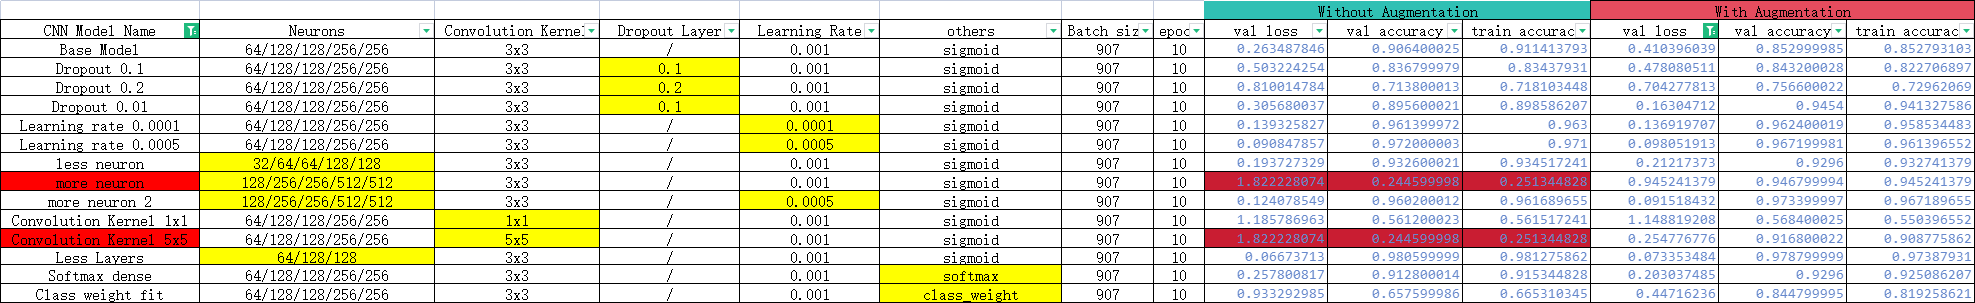    
<br></br> 

ResNet:
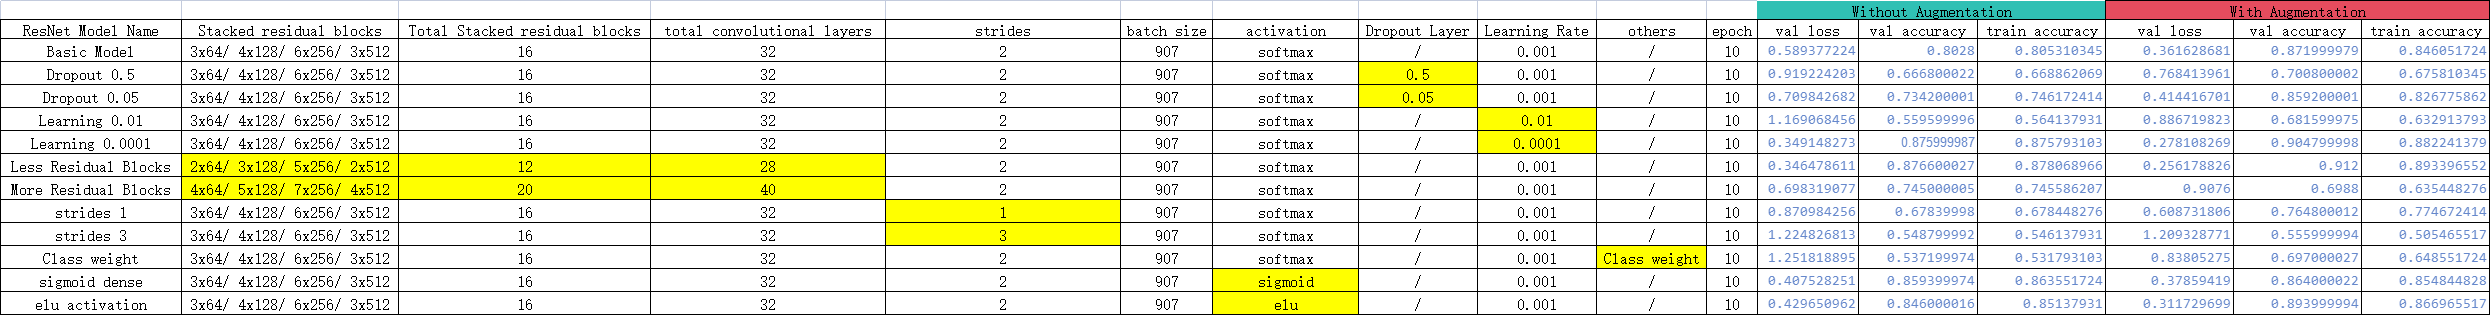


# Section 4 - Results

### <i>4.1 - Performance comparison</i>

The tables below present the performance of each model created under the circumstance with/without data augmentation applied. The <b>Mean</b> and <b>Standard Deviation (Std)</b> are obtained by training the model several times and using a different data or parameters each time:  
-RF and DNN = 5 times, random seed.  
-CNN and ResNet = 15 times with different parameters to compare the impact of parameters on the models' performance.   
* The final configuration for the Random Forest classifier is <b>min_samples_split=5</b>, and the others are set as default.  
* The final configuration for the DNN is <b>Hidden layers: (500, 300, 100), Optimizer = AdamW, Activation = ReLU, Kernel_Initializer = Default Dropout rate = 0.2, epoch = 50</b>, and the others are set as default.
* The final configuration for CNN model is <b>Learning Rate = 0.0005,Dense Size=512, Neuron= 128/128/256/256/512.</b>
* The final configuration for ResNet is <b>Learning Rate = 0.0001,Stacked Residual Blocks = 3x64/ 4x128/ 6x256/ 3x512, Strids=2, Activation=elu.</b>

<i>With Data Augmentation</i>

|                   | Random Forest |  DNN  | CNN | ResNet |
| :---------------  | ------------: | -----:| ---------:| ---------:|
| Mean (Training)   |     0.999     | 0.576 |      0.8778    |    0.7536     |
| Std (Training)    |     0         | 0     |      0.1271    |    0.1282     |
| Mean (Validation) |     0.418     | 0.423 |      0.8869    |    0.7838     |
| Std (Validation)  |     0.008     | 0     |      0.1204    |    0.1158     |
| Accurcy (Kaggle)  |     0.43      | 0.45  |      0.52    |    0.548     |  

<i>Without Data Augmentation</i>

|                   | Random Forest |  DNN  | CNN | ResNet |
| :---------------  | ------------: | -----:| ---------:| ---------:|
| Mean (Training)   |     0.999     | 0.676 |      0.8597    |    0.7296     |
| Std (Training)    |     0         | 0     |      0.1377    |    0.1311     |
| Mean (Validation) |     0.443     | 0.443 |      0.8577    |    0.7276     |
| Std (Validation)  |     0.003     | 0     |      0.1385    |    0.1294     |
| Accurcy (Kaggle)  |     0.45      | 0.46  |      0.515    |    0.55     |

In [ ]:
# Results of Standard ML Baseline ML: Random Forest
import statistics

# Training and validation set used. Calculating the mean and std of a model's accuracy
# (i.e., train the same model 5 times, then using different random seed each time)
def get_train_val_performance(new_X_train_partial, new_y_train_partial, X_val, y_val, command):
  # Create a list of different random seeds
  random_seed = [13, 22, 30, 42, 78]
  train_scores = []
  val_scores = []
  if command == "ML":
    for seed in random_seed:
      rf = RandomForestClassifier(min_samples_split=5, random_state=seed)
      train_acc, val_acc = show_clf_performance(rf, new_X_train_partial,
                                                new_y_train_partial, X_val, y_val)
      train_scores.append(train_acc)
      val_scores.append(val_acc)
    print("Mean(Training):", round(statistics.mean(train_scores),3),
          "Std(Training):", round(statistics.stdev(train_scores),3))
    print("Mean(Validation):", round(statistics.mean(val_scores),3),
          "Std(Validation):", round(statistics.stdev(val_scores),3))
  else:
    for seed in random_seed:
      tf.keras.utils.set_random_seed(seed)
      optimiser = tf.keras.optimizers.AdamW(learning_rate=0.001)
      our_DNN = diff_Config_DNN("relu", None)
      train_acc, val_acc = get_DNN_performance(our_DNN, optimiser, new_X_train_partial,
                                               new_y_train_partial, X_val, y_val, epochs_num=50)
      train_scores.append(train_acc)
      val_scores.append(val_acc)
    print("Mean(Training):", round(statistics.mean(train_scores),3),
          "Std(Training):", round(statistics.stdev(train_scores),3))
    print("Mean(Validation):", round(statistics.mean(val_scores),3),
          "Std(Validation):", round(statistics.stdev(val_scores),3))

# The entire training set used. Generate a CSV file containing predictions on real test set
def get_test_prediction(whole_X_train, whole_y_train, real_test, command):
  if command == "ML":
    # The score on the Kaggle should be reproducible, therefore random_state should be fixed
    final_rf = RandomForestClassifier(min_samples_split=5, random_state=42)
    final_rf.fit(whole_X_train, whole_y_train)
    predictions = final_rf.predict(real_test)
    predictions_ML = pd.DataFrame(predictions, columns=['emotion'])
    predictions_ML['id'] = test_df.iloc[:, 0].values
    predictions_ML = predictions_ML[['id', 'emotion']]
    predictions_ML.to_csv('emotions_predictions_ML.csv', index=False)
  else:
    tf.keras.utils.set_random_seed(42)
    final_DNN = diff_Config_DNN("relu", None)
    optimiser = tf.keras.optimizers.AdamW(learning_rate=0.001)
    final_DNN.compile(loss="sparse_categorical_crossentropy", optimizer=optimiser, metrics=["accuracy"])
    final_DNN.fit(whole_X_train, whole_y_train, epochs=50, verbose=0)
    predictions = final_DNN.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    predictions_DNN = pd.DataFrame(y_pred, columns=['emotion'])
    predictions_DNN['id'] = test_df.iloc[:, 0].values
    predictions_DNN = predictions_DNN[['id', 'emotion']]
    predictions_DNN.to_csv('emotions_predictions_DNN.csv', index=False)

In [ ]:
# Test the performance with data augmentation applied.
def augmented_DS_performance(command):
  augmented_X_train_partial, augmented_y_train_partial = larger_DS(X_train_partial, y_train_partial)
  augmented_X_train, augmented_y_train = larger_DS(X_train, y_train)
  if command == "ML":
    get_train_val_performance(augmented_X_train_partial, augmented_y_train_partial, X_val, y_val, "ML")
    get_test_prediction(augmented_X_train, augmented_y_train, X_test, "ML")
  else:
    get_train_val_performance(augmented_X_train_partial, pd.Series(augmented_y_train_partial), X_val, y_val, "DNN")
    get_test_prediction(augmented_X_train, pd.Series(augmented_y_train), X_test, "DNN")

# Test the performance without data augmentation applied
def normal_DS_performance(command):
  if command == "ML":
    get_train_val_performance(X_train_partial, y_train_partial, X_val, y_val, "ML")
    get_test_prediction(X_train, y_train, X_test, "ML")
  else:
    get_train_val_performance(X_train_partial, y_train_partial, X_val, y_val, "DNN")
    get_test_prediction(X_train, y_train, X_test, "DNN")

In [ ]:
# Get the performance of the Random forest and DNN presented in the table above

# The following will give the performance of the final random forest, including
# the mean and std of training accuracy and the mean and std of validation accuracy.
# The predictions on real test set will be stored into a CSV file.
# Recommend: Run the following code line by line, otherwise the CSV file will replace.

# augmented_DS_performance("ML") # With using augmented data
# normal_DS_performance("ML") # Without using augmented data

# augmented_DS_performance("DNN")
# normal_DS_performance("DNN")

### <i>4.2 - Short summary</i>

For this task (Emotion recognition), we have experimented a standard ML random forest classifier model, a deep neural network with 3 hidden layers, a complex NN model based on CNN (Convolutional Neural Network) architecture, and another complex NN model based on ResNet (Residual Network) architecture.  
* For the random forest model, we tried to fine-tune the hyperparameter <b>min_samples_split</b> and we found that the model accuracy increased when we tuned this hyperparameter from 2 (the default value) to 5, but the model accuracy started going down when this hyperparameter up to 10. Also, it was trivial to notice that by increasing the number of decision trees of the random forest, the model's performance would be improved; however, we did not go for that because it was very computationally expansive. At the end, the training accuracy of Random Forest reached 99% that was greatly exceed its testing score, which this was severely overfitting.  
* For DNNs, due to the same concern we had with Random Forest, we did not choose to fine-tune parameters like number of layers and number of neurons. The guideline about setting DNN configuration was referred from [1]. The performance of the DNN model performed slightly better than the Random Forest, the extend of overfitting is reduced.  
* In testing CNN, key findings include the trade-off between increased neuron count and higher accuracy against longer training and potential overfitting. Learning rates around 0.001 were optimal, and large convolution kernels risked overfitting. More layers did not necessarily improve ResNet performance, suggesting limits to complexity benefits.  
* For ResNet, using fewer, efficiently designed layers maintained accuracy and indicated overfitting with too many layers. Strides of 1 captured detail without improving accuracy, while strides of 3 reduced it due to lost information. Class weight adjustments and sigmoid activation in dense layers had a marginal positive impact on accuracy, whereas ELU activation was effective against vanishing gradients.

[1] "Hands-on Machine Learning With Scikit-Learn, Keras and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", 3rd edition, page 293-294

# Section 5 - Summery and Next Steps for Enhanced Emotion Recognition

### Project Summery

Our final decision for this project is to utilize a ResNet model without applying data augmentation in above configuration. Which give us a **85% validation accuracy** based on the first 5000 image, and **0.58 in kaggle** competation.

Given this scenario, the decision to disuse data augmentation in favor of a standard ResNet model is justified by the relative gains in performance V.S. the increased training duration. In this project, a 7% improvement in performance might not warrant doubling the training time, particularly when we have limited time and computational resources. Furthermore, the existing accuracy without augmentation already meets the project requirements, the additional time and resources required for a small increase might not be considered cost-effective.

The ResNet model is recommended not only because it has the best performance overall, but also ResNet is a deep network and capable to learn complex patterns effectively. As a task like this emotional recognition, ResNet has an inherent structure  to help mitigate the vanishing gradient problem, enabling training of much deeper networks without compromising on the ability to learn.



### Enhancement for Next Step

⁤Due to the project limit, our data preprocessing is only include sample data augmentation. ⁤⁤For the problem of emotion recognition, we chould have better data processing methods. ⁤⁤For example, the class distribution in the training data is not balanced, which we take into account, but since we focus on finding the best parameters, including class weight parameter slows down our training epoch. ⁤⁤Possible follow-up measures are: ⁤


**⁤-Synthetic Data Generation:** We can try techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate new, synthetic examples of the underrepresented classes. ⁤


**⁤-Advanced Preprocessing:** Spend more time on data preprocessing, such as feature engineering or extraction, to identify key features that are indicative of specific emotions. ⁤


**⁤-Combined Models Methods:** Combine multiple models, particularly those trained on different resampled subsets of the data, to improve the final prediction. ⁤


⁤By implementing these methods, we are confident that we can improve the prediction performance.